In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Import the Required Libraries

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
import random
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report, f1_score

import tensorflow as tf
import tensorflow_hub as hub
#import efficientnet.keras as efn
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 2. Load the Image Training and Validation Datasets

## i. Get the Image Dataset Paths

In [100]:
# Define data directories
train_dir = '/kaggle/input/image-classification-dataset/train-valid-set/train'
validation_dir = '/kaggle/input/image-classification-dataset/train-valid-set/val'

## ii. Load Image Datasets and Apply Augmentations

In [101]:
# Define image data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')

# Flow validation images in batches using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')



Found 2433 images belonging to 7 classes.
Found 610 images belonging to 7 classes.


## iii. Get the Label Mappings

In [102]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : bus
1 : car
2 : cat
3 : cricket
4 : dog
5 : football
6 : product


# 3. Plotting Sample Training Images

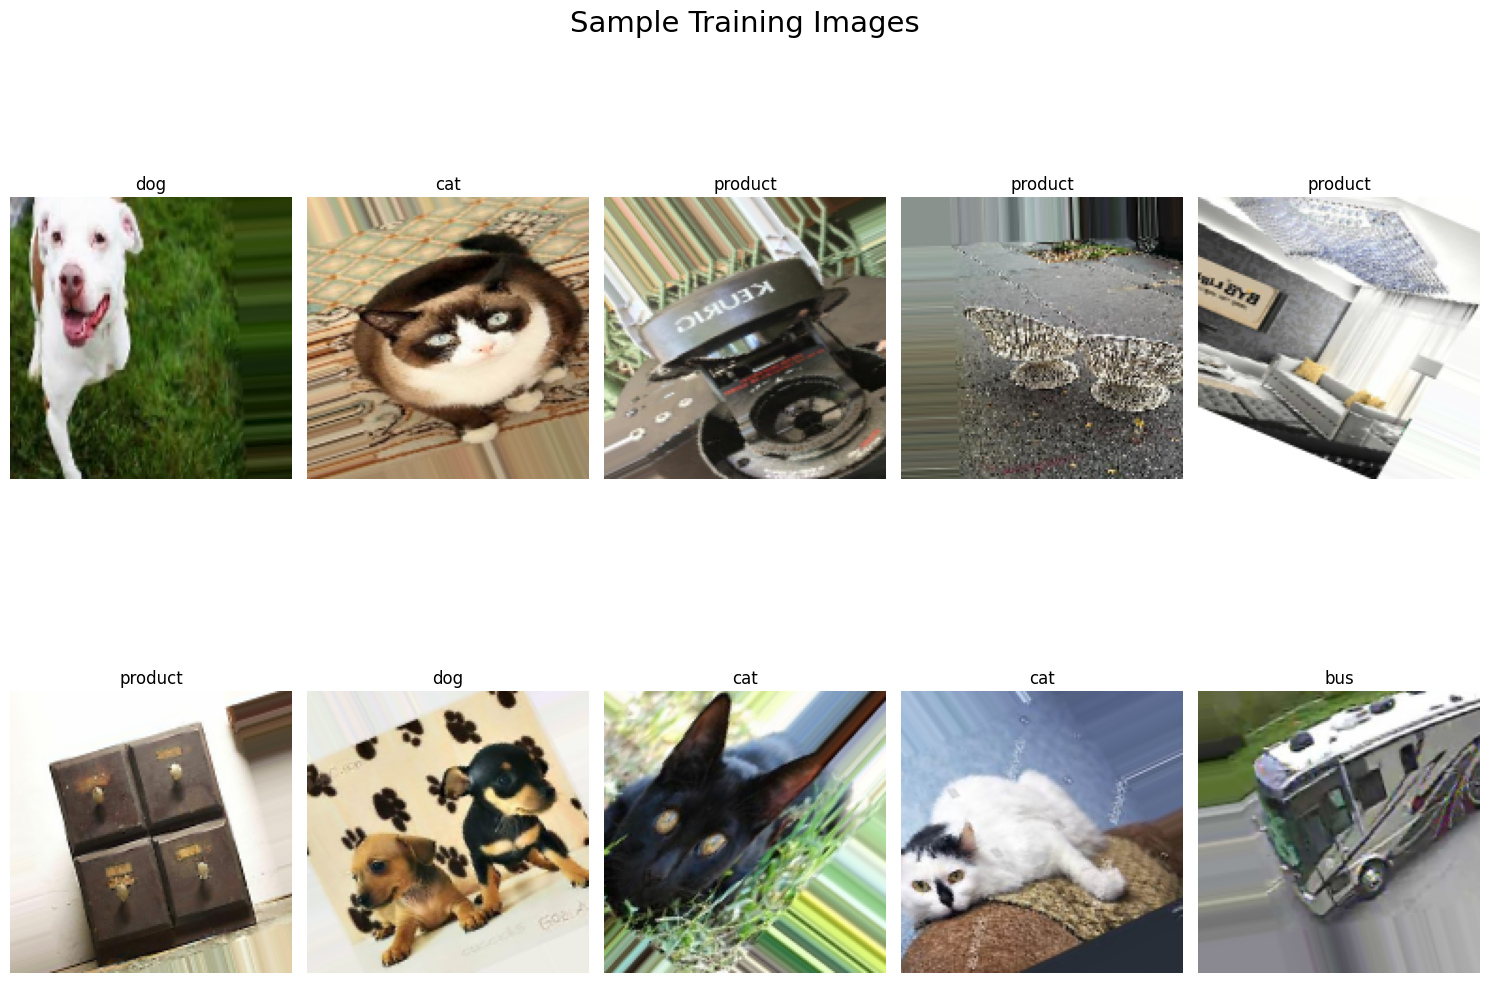

In [103]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# 4. Training and Testing various CNN Models

## i. Create first CNN Model from scratch

In [111]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(7, activation='softmax')
    ])
    return model

In [112]:
# Create the model
model = create_model(input_shape=(150, 150, 3), num_classes=7)

In [107]:
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_101 (Conv2D)             │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,456,199 (13.18 MB)

 Trainable params: 3,456,199 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

None


### a. Defining Callback and Optimizer

In [113]:
#  Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
# Adam Optimizer
optimizer = Adam(learning_rate=0.001)

### b. Compile the Model

In [114]:
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

### c. Training the Model

In [115]:
history = model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50


W0000 00:00:1711174096.929357     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711174113.982914     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 - 23s - 303ms/step - accuracy: 0.2741 - loss: 1.6996 - val_accuracy: 0.4197 - val_loss: 1.3470 - learning_rate: 0.0010
Epoch 2/50


W0000 00:00:1711174115.752914     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 - 20s - 256ms/step - accuracy: 0.3938 - loss: 1.4958 - val_accuracy: 0.5115 - val_loss: 1.2190 - learning_rate: 0.0010
Epoch 3/50
77/77 - 19s - 251ms/step - accuracy: 0.4509 - loss: 1.3266 - val_accuracy: 0.5525 - val_loss: 1.1699 - learning_rate: 0.0010
Epoch 4/50
77/77 - 17s - 223ms/step - accuracy: 0.5002 - loss: 1.1857 - val_accuracy: 0.4393 - val_loss: 1.4025 - learning_rate: 0.0010
Epoch 5/50
77/77 - 21s - 273ms/step - accuracy: 0.5224 - loss: 1.1372 - val_accuracy: 0.5852 - val_loss: 1.0425 - learning_rate: 0.0010
Epoch 6/50
77/77 - 18s - 233ms/step - accuracy: 0.5582 - loss: 1.0771 - val_accuracy: 0.5574 - val_loss: 1.0606 - learning_rate: 0.0010
Epoch 7/50
77/77 - 18s - 227ms/step - accuracy: 0.5730 - loss: 1.0182 - val_accuracy: 0.5590 - val_loss: 1.1765 - learning_rate: 0.0010
Epoch 8/50
77/77 - 18s - 229ms/step - accuracy: 0.5767 - loss: 1.0162 - val_accuracy: 0.6000 - val_loss: 0.8958 - learning_rate: 0.0010
Epoch 9/50
77/77 - 18s - 232ms/step - accuracy: 0.5939 - lo

### d. Evaluating and Plotting the Model Metrics

#### Evalutaing F1-Score on Validation Set

In [116]:
def calculate_f1_score(model, validation_generator):
    # Predict the classes for the validation set
    validation_generator.reset()  # Reset the generator to the beginning of the validation set
    y_pred = model.predict(validation_generator, steps=len(validation_generator), verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get the true classes for the validation set
    y_true = validation_generator.classes

    # Calculate the F1-score
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    return f1

    # After training the model
    f1 = calculate_f1_score(model, validation_generator)
    print("F1-score:", f1)

In [117]:
calculate_f1_score(model, validation_generator)

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

W0000 00:00:1711175069.067738     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


W0000 00:00:1711175070.684330     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


0.20008179853742197

#### Plotting training and validation accuracy, loss and learning rate

In [118]:
def plot_training_history(train_accuracy, val_accuracy, train_loss, val_loss, learning_rate=None):
    fig, ax = plt.subplots(nrows=3 if learning_rate is not None else 2, ncols=1, figsize=(10, 8))
    
    ax[0].set_title('Training Accuracy vs. Epochs')
    ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
    ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='best')
    
    ax[1].set_title('Training/Validation Loss vs. Epochs')
    ax[1].plot(train_loss, 'o-', label='Train Loss')
    ax[1].plot(val_loss, 'o-', label='Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='best')
    
    if learning_rate is not None:
        ax[2].set_title('Learning Rate vs. Epochs')
        ax[2].plot(learning_rate, 'o-', label='Learning Rate')
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylabel('Learning Rate')
        ax[2].legend(loc='best')
    
    plt.tight_layout()
    plt.show()

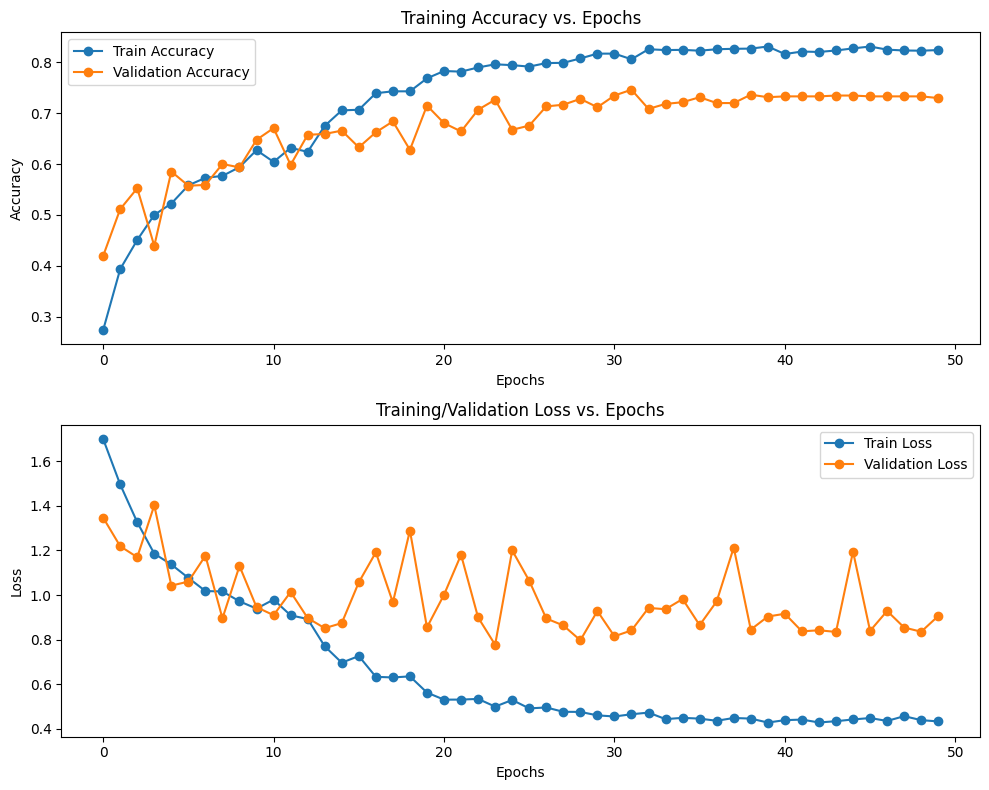

In [119]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# If you have the learning rate in the history, pass it to the function
if 'lr' in history.history:
    learning_rate = history.history['lr']
    plot_training_history(train_accuracy, val_accuracy, train_loss, val_loss, learning_rate)
else:
    plot_training_history(train_accuracy, val_accuracy, train_loss, val_loss)

### e. Testing the Model on Test Set

In [122]:
def generate_predictions_and_save(model, test_data_dir, output_file):
    # Get a list of image file paths
    image_paths = [os.path.join(test_data_dir, f) for f in os.listdir(test_data_dir) if f.endswith(('.jpg', '.png'))]

    # Load and preprocess the images
    images = []
    for path in image_paths:
        img = load_img(path, target_size=(150, 150))  # Adjust target size as needed
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Rescale pixel values to [0, 1]
        images.append(img_array)

    images = np.array(images)  # Convert to numpy array

    # Generate Predictions
    predictions = model.predict(images, batch_size=32, verbose=1)

    # Define a dictionary to map numerical labels to their corresponding string representations
    label_map = {0: 'bus', 1: 'car', 2: 'cat', 3: 'cricket', 4: 'dog', 5: 'football', 6: 'product'}  # Define your class labels accordingly

    # Get the filenames (IDs) for the test data
    filenames = [os.path.basename(path) for path in image_paths]
    ids = [int(filename.split('YehKarkeDikhaao')[1].split('.')[0]) for filename in filenames]  # Extract IDs from filenames

    # Convert numerical predictions to string labels
    pred_labels = [label_map[label] for label in predictions.argmax(axis=1)]

    # Create Submission File
    submission_lines = []
    submission_lines.append('id,label')  # Add header

    # Create submission lines in the required format
    for id, label in zip(ids, pred_labels):
        submission_lines.append(f'{id},{label}')

    # Save the submission lines to a CSV file
    with open(output_file, 'w') as f:
        f.write('\n'.join(submission_lines))

    print("Predictions saved to:", output_file)
    
    return predictions

In [123]:
test_data_dir = '/kaggle/input/image-classification-dataset/test'
predictions = generate_predictions_and_save(model, test_data_dir, '/kaggle/working/predictions.csv' )

22/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

W0000 00:00:1711175204.266439     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Predictions saved to: /kaggle/working/predictions.csv


W0000 00:00:1711175204.944222     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### f. Model Prediction on the Test Dataset

In [125]:
import random

def visualize_predictions(model, test_data_dir, predictions, num_images=10):
    # Get a list of image file paths
    image_paths = [os.path.join(test_data_dir, f) for f in os.listdir(test_data_dir) if f.endswith(('.jpg', '.png'))]

    # Randomly shuffle the image paths
    random.shuffle(image_paths)

    # Load and preprocess the images
    images = []
    for path in image_paths[:num_images]:
        img = load_img(path, target_size=(150, 150))  # Adjust target size as needed
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Rescale pixel values to [0, 1]
        images.append(img_array)

    images = np.array(images)  # Convert to numpy array

    # Define a dictionary to map numerical labels to their corresponding string representations
    label_map = {0: 'bus', 1: 'car', 2: 'cat', 3: 'cricket', 4: 'dog', 5: 'football', 6: 'product'}  # Define your class labels accordingly

    # Get the filenames (IDs) for the test data
    filenames = [os.path.basename(path) for path in image_paths[:num_images]]
    ids = [int(filename.split('YehKarkeDikhaao')[1].split('.')[0]) for filename in filenames]  # Extract IDs from filenames

    # Convert numerical predictions to string labels
    pred_labels = [label_map[label] for label in predictions.argmax(axis=1)]

    # Visualize predictions
    num_rows = 2
    num_cols = 5
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 10))

    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            if idx < num_images:
                predicted_label = pred_labels[idx]
                ax[i, j].set_title(f"{predicted_label}")
                ax[i, j].imshow(images[idx])
                ax[i, j].axis("off")

    plt.tight_layout()
    plt.suptitle("Test Dataset Predictions", fontsize=20)
    plt.show()

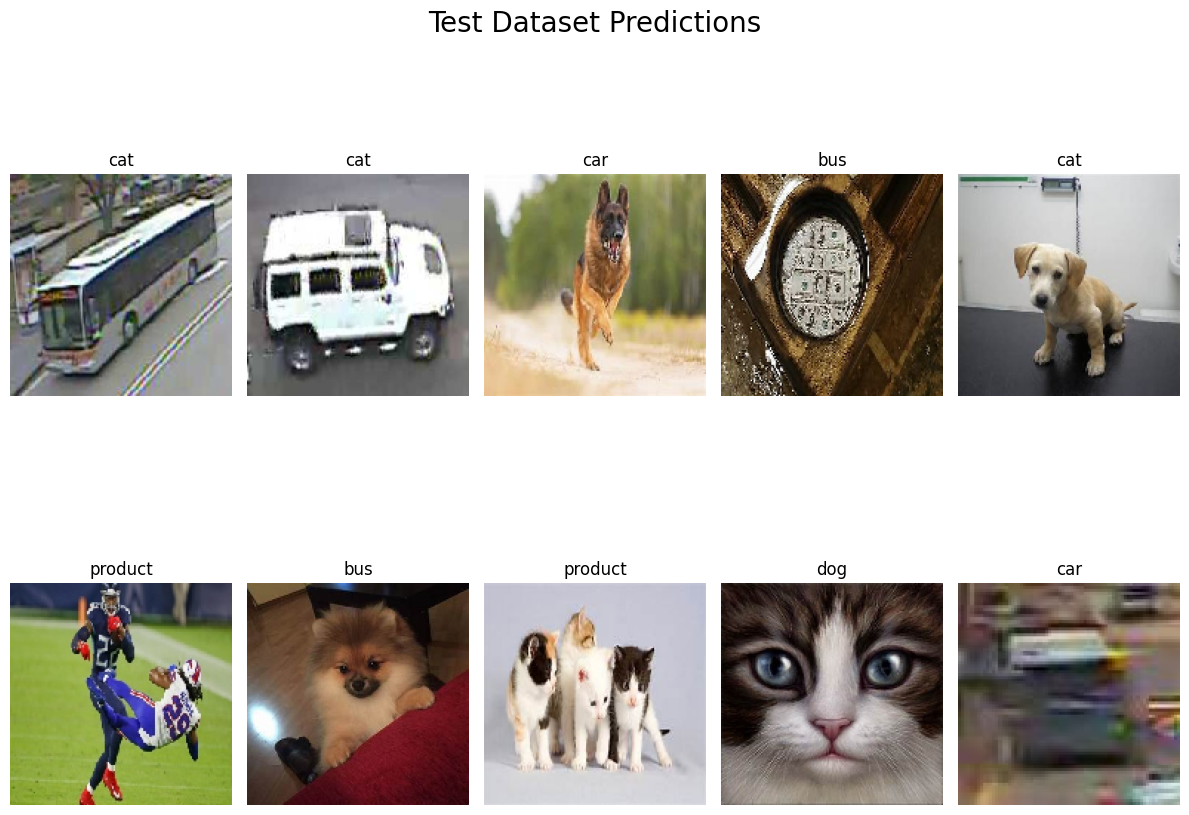

In [126]:
visualize_predictions(model, test_data_dir, predictions, num_images=10)

## ii. Create second CNN Model from scratch

In [128]:
def create_model_1():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(150, 150, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=7, activation='softmax')
    ])

    return model

In [129]:
# Create the model
model = create_model_1()

In [130]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_109 (Conv2D)             │ (None, 146, 146, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_97 (Activation)      │ (None, 146, 146, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 73, 73, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 71, 71, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_98 (Activation)      │ (None, 71, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 35, 35, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 33, 33, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_99 (Activation)      │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,202,087 (8.40 MB)

 Trainable params: 2,201,639 (8.40 MB)

 Non-trainable params: 448 (1.75 KB)

### a. Defining Callback and Optimizer and compiling the model

In [131]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

### b. Training the Model

In [132]:
history = model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50


W0000 00:00:1711175385.184001     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711175403.864971     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 - 29s - 374ms/step - accuracy: 0.3300 - loss: 3.5074 - val_accuracy: 0.2623 - val_loss: 3.6436 - learning_rate: 0.0010
Epoch 2/50


W0000 00:00:1711175405.515831     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 - 17s - 225ms/step - accuracy: 0.4118 - loss: 2.4978 - val_accuracy: 0.2721 - val_loss: 4.1110 - learning_rate: 0.0010
Epoch 3/50
77/77 - 18s - 230ms/step - accuracy: 0.4291 - loss: 2.2327 - val_accuracy: 0.2541 - val_loss: 4.7071 - learning_rate: 0.0010
Epoch 4/50
77/77 - 18s - 229ms/step - accuracy: 0.4710 - loss: 1.6271 - val_accuracy: 0.2639 - val_loss: 2.9282 - learning_rate: 0.0010
Epoch 5/50
77/77 - 18s - 230ms/step - accuracy: 0.5051 - loss: 1.3852 - val_accuracy: 0.2820 - val_loss: 2.9225 - learning_rate: 0.0010
Epoch 6/50
77/77 - 17s - 224ms/step - accuracy: 0.5171 - loss: 1.2853 - val_accuracy: 0.4295 - val_loss: 1.3262 - learning_rate: 0.0010
Epoch 7/50
77/77 - 18s - 230ms/step - accuracy: 0.5512 - loss: 1.1742 - val_accuracy: 0.3066 - val_loss: 1.8209 - learning_rate: 0.0010
Epoch 8/50
77/77 - 18s - 231ms/step - accuracy: 0.5742 - loss: 1.1193 - val_accuracy: 0.5590 - val_loss: 1.1805 - learning_rate: 0.0010
Epoch 9/50
77/77 - 18s - 228ms/step - accuracy: 0.5750 - lo

### c. Evalutaing F1-Score on Validation Set

In [133]:
calculate_f1_score(model, validation_generator)

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

W0000 00:00:1711176332.536980     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


W0000 00:00:1711176334.109356     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


0.1801358559249796

### d. Plotting training and validation accuracy, loss and learning rate

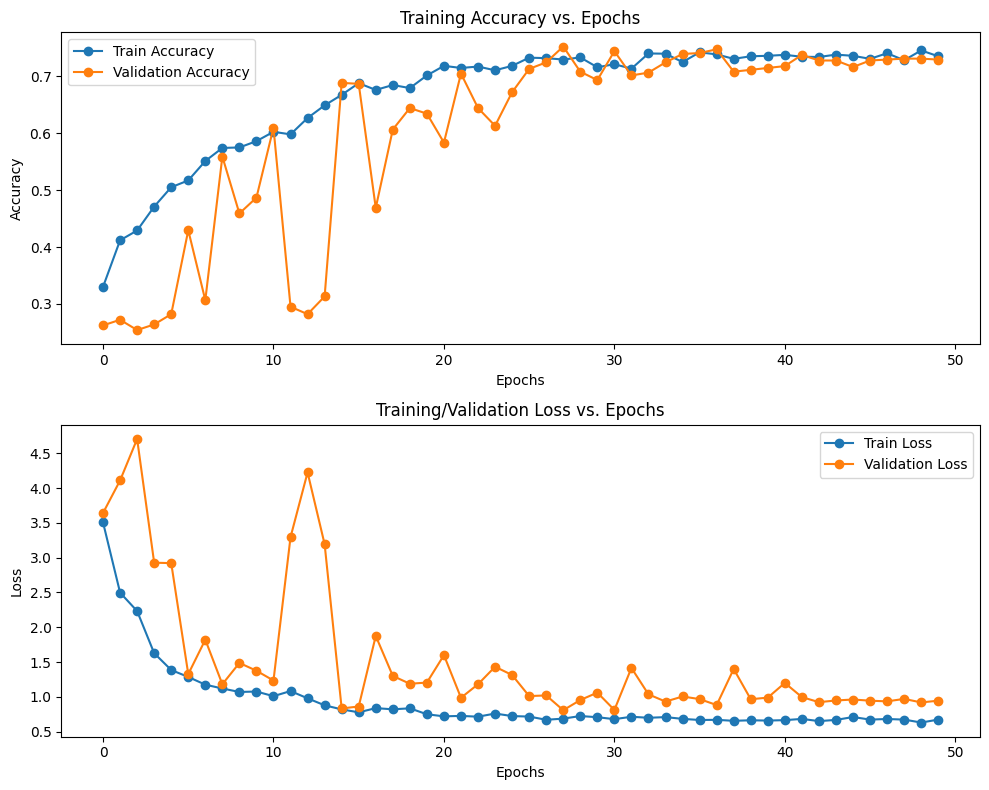

In [134]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# If you have the learning rate in the history, pass it to the function
if 'lr' in history.history:
    learning_rate = history.history['lr']
    plot_training_history(train_accuracy, val_accuracy, train_loss, val_loss, learning_rate)
else:
    plot_training_history(train_accuracy, val_accuracy, train_loss, val_loss)

### e. Testing the Model on Test Set

In [135]:
predictions = generate_predictions_and_save(model, test_data_dir, '/kaggle/working/predictions2.csv' )

13/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

W0000 00:00:1711176360.403745     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Predictions saved to: /kaggle/working/predictions2.csv


W0000 00:00:1711176361.360512     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### f. Model Prediction on the Test Dataset

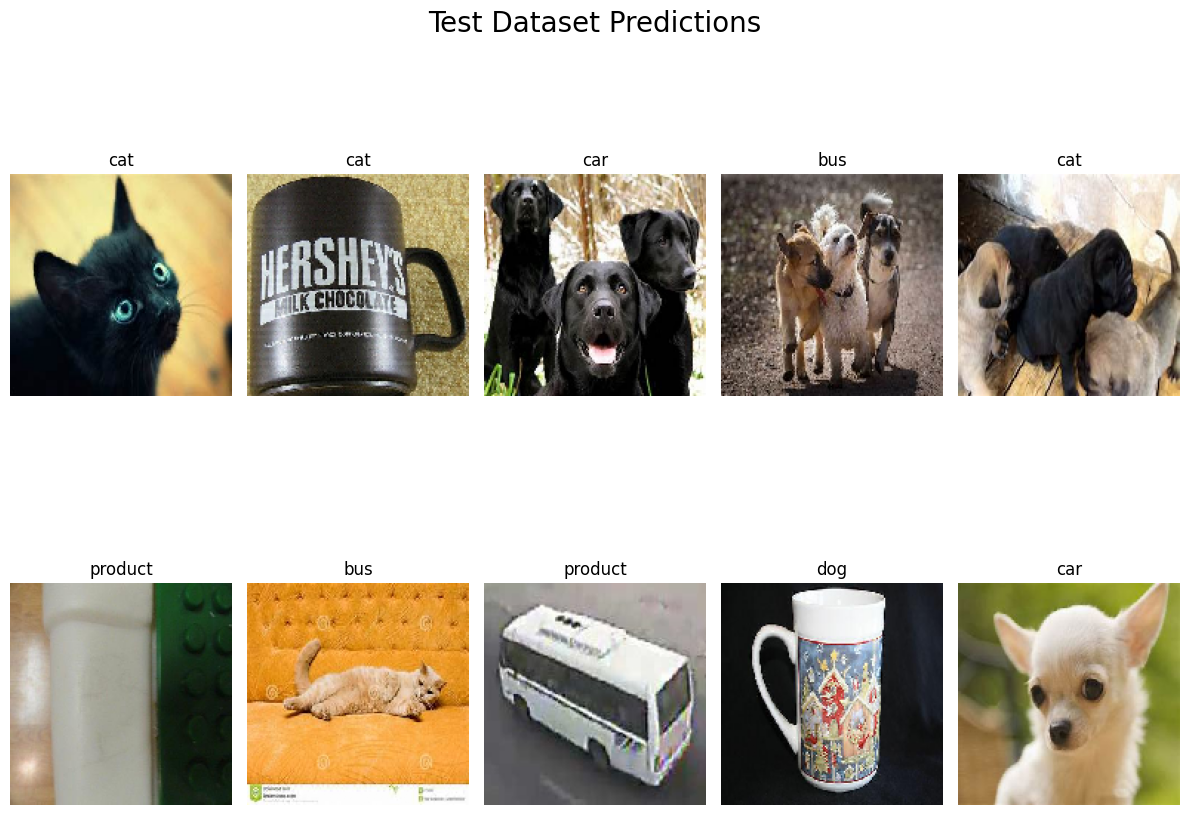

In [136]:
visualize_predictions(model, test_data_dir, predictions, num_images=10)

## iii. Using VGG-16

In [137]:
# Load VGG16 model without the top layer
base_model = VGG16(input_shape=(150, 150, 3),  # Shape of our images
                   include_top=False,  # Leave out the last fully connected layer
                   weights='imagenet')

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 7 nodes for classification output
x = tf.keras.layers.Dense(7, activation='softmax')(x)

# Create the model
model = tf.keras.models.Model(base_model.input, x)

# Change the optimizer to Adam with learning rate 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Calculate the loss for categorical multilabel images
loss = tf.keras.losses.CategoricalCrossentropy()

In [138]:
# Display model summary
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,913,095 (72.15 MB)

 Trainable params: 4,198,407 (16.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### a. Defining Callback and Optimizer and compiling the model

In [139]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

### b. Training the Model

In [140]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 50, verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50


W0000 00:00:1711176387.253776     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711176404.529200     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 - 24s - 240ms/step - accuracy: 0.6194 - loss: 1.2071 - val_accuracy: 0.8328 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 2/50


W0000 00:00:1711176406.466772     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 - 19s - 186ms/step - accuracy: 0.7542 - loss: 0.6168 - val_accuracy: 0.8475 - val_loss: 0.3774 - learning_rate: 0.0010
Epoch 3/50
100/100 - 18s - 182ms/step - accuracy: 0.7834 - loss: 0.5764 - val_accuracy: 0.8623 - val_loss: 0.3332 - learning_rate: 0.0010
Epoch 4/50
100/100 - 18s - 181ms/step - accuracy: 0.8089 - loss: 0.4975 - val_accuracy: 0.8787 - val_loss: 0.2812 - learning_rate: 0.0010
Epoch 5/50
100/100 - 18s - 182ms/step - accuracy: 0.8319 - loss: 0.4379 - val_accuracy: 0.8852 - val_loss: 0.3094 - learning_rate: 0.0010
Epoch 6/50
100/100 - 19s - 189ms/step - accuracy: 0.8220 - loss: 0.4502 - val_accuracy: 0.9033 - val_loss: 0.2547 - learning_rate: 0.0010
Epoch 7/50
100/100 - 19s - 187ms/step - accuracy: 0.8422 - loss: 0.4481 - val_accuracy: 0.8787 - val_loss: 0.2830 - learning_rate: 0.0010
Epoch 8/50
100/100 - 18s - 185ms/step - accuracy: 0.8372 - loss: 0.4243 - val_accuracy: 0.8885 - val_loss: 0.2612 - learning_rate: 0.0010
Epoch 9/50
100/100 - 18s - 182ms/step - accur

### c. Evalutaing F1-Score on Validation Set

In [141]:
calculate_f1_score(model, validation_generator)

 3/20 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step 

W0000 00:00:1711177349.714008     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


W0000 00:00:1711177351.529490     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


0.16596981703368882

### d. Plotting training and validation accuracy, loss and learning rate

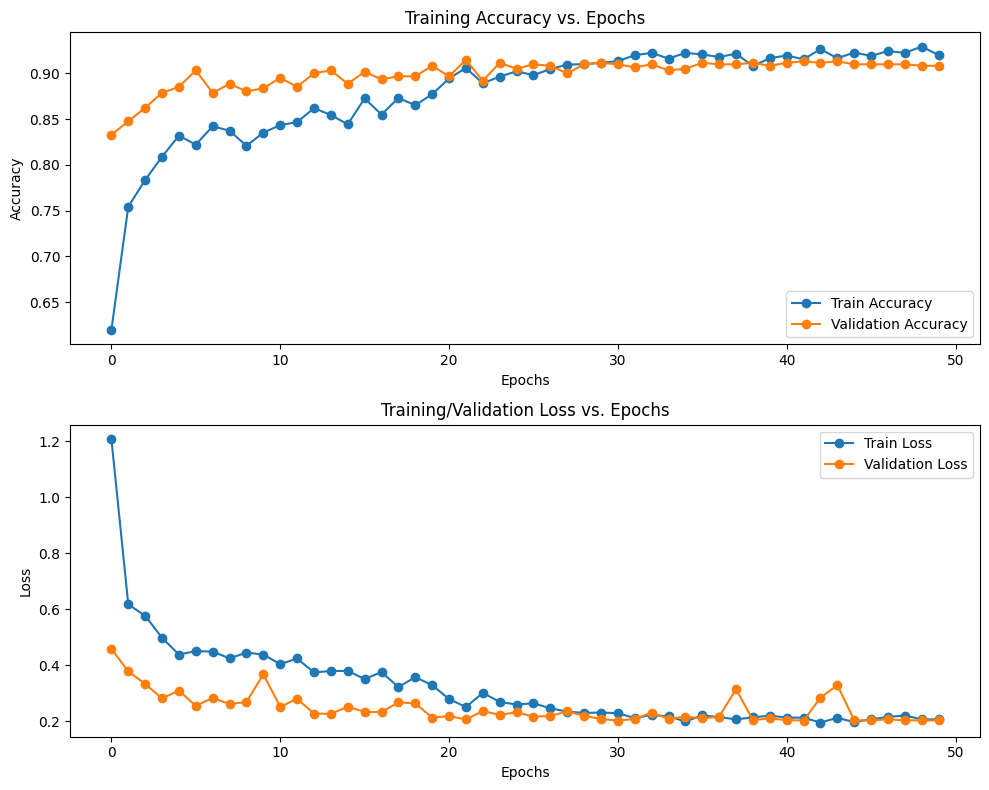

In [142]:
train_accuracy = vgghist.history['accuracy']
val_accuracy = vgghist.history['val_accuracy']
train_loss = vgghist.history['loss']
val_loss = vgghist.history['val_loss']

# If you have the learning rate in the history, pass it to the function
if 'lr' in vgghist.history:
    learning_rate = vgghist.history['lr']
    plot_training_history(train_accuracy, val_accuracy, train_loss, val_loss, learning_rate)
else:
    plot_training_history(train_accuracy, val_accuracy, train_loss, val_loss)

### e. Testing the Model on Test Set

In [143]:
predictions = generate_predictions_and_save(model, test_data_dir, '/kaggle/working/predictions3.csv' )

 3/44 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step

W0000 00:00:1711177378.893660     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step
Predictions saved to: /kaggle/working/predictions3.csv


W0000 00:00:1711177382.364690     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### f. Model Prediction on the Test Dataset

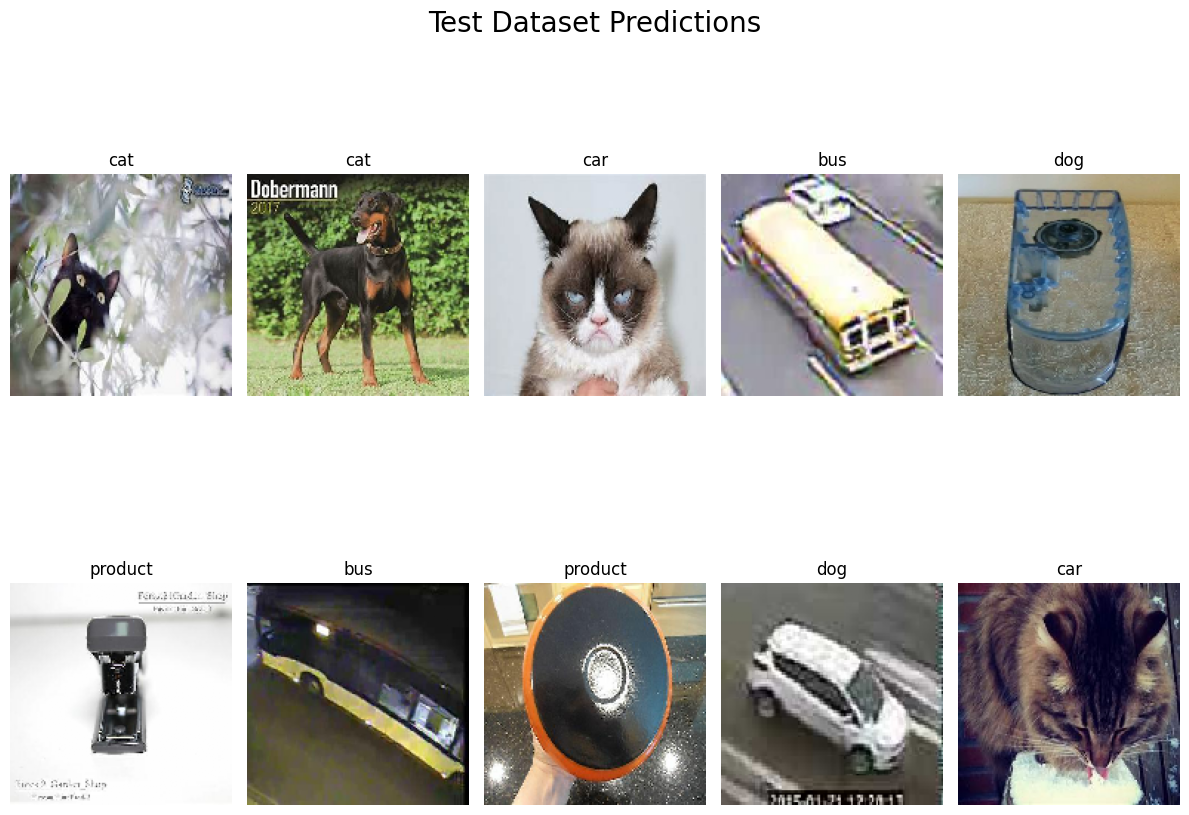

In [144]:
visualize_predictions(model, test_data_dir, predictions, num_images=10)

## iv. Using Inception-V3

In [145]:
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

# Change the optimizer to Adam with learning rate 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Calculate the loss for categorical multilabel images
loss = tf.keras.losses.CategoricalCrossentropy()

In [146]:
# Display model summary
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 74, 74,    │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │         96 │ conv2d_112[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_100      │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_113 (Conv2D) │ (None, 72, 72,    │      9,216 │ activation_100[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_113[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_101      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 72, 72,    │     18,432 │ activation_101[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_114[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_102      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 35, 35,    │          0 │ activation_102[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 35, 35,    │      5,120 │ max_pooling2d_22… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_115[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_103      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 33, 33,    │    138,240 │ activation_103[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_116[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_104      │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 40,685,351 (155.20 MB)

 Trainable params: 18,882,567 (72.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

### a. Defining Callback and Optimizer and compiling the model

In [147]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

### b. Training the Model

In [148]:
inc_hist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 50, verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50


W0000 00:00:1711177478.272790     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711177504.341114     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 - 45s - 448ms/step - accuracy: 0.6926 - loss: 7.5133 - val_accuracy: 0.8951 - val_loss: 0.3471 - learning_rate: 0.0010
Epoch 2/50


W0000 00:00:1711177508.381104     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 - 18s - 175ms/step - accuracy: 0.8598 - loss: 0.4741 - val_accuracy: 0.9459 - val_loss: 0.2024 - learning_rate: 0.0010
Epoch 3/50
100/100 - 18s - 175ms/step - accuracy: 0.8598 - loss: 0.3893 - val_accuracy: 0.9328 - val_loss: 0.1939 - learning_rate: 0.0010
Epoch 4/50
100/100 - 18s - 180ms/step - accuracy: 0.8775 - loss: 0.3578 - val_accuracy: 0.9213 - val_loss: 0.2408 - learning_rate: 0.0010
Epoch 5/50
100/100 - 18s - 178ms/step - accuracy: 0.8820 - loss: 0.3348 - val_accuracy: 0.9377 - val_loss: 0.1971 - learning_rate: 0.0010
Epoch 6/50
100/100 - 18s - 176ms/step - accuracy: 0.8771 - loss: 0.4148 - val_accuracy: 0.9262 - val_loss: 0.2898 - learning_rate: 0.0010
Epoch 7/50
100/100 - 18s - 178ms/step - accuracy: 0.8763 - loss: 0.3886 - val_accuracy: 0.9377 - val_loss: 0.1950 - learning_rate: 0.0010
Epoch 8/50
100/100 - 18s - 181ms/step - accuracy: 0.8837 - loss: 0.3348 - val_accuracy: 0.9410 - val_loss: 0.1873 - learning_rate: 0.0010
Epoch 9/50
100/100 - 18s - 176ms/step - accur

### c. Evalutaing F1-Score on Validation Set

In [149]:
calculate_f1_score(model, validation_generator)

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

W0000 00:00:1711178649.956253     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step


W0000 00:00:1711178656.433175     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


0.18374307501312784

### d. Plotting training and validation accuracy, loss and learning rate

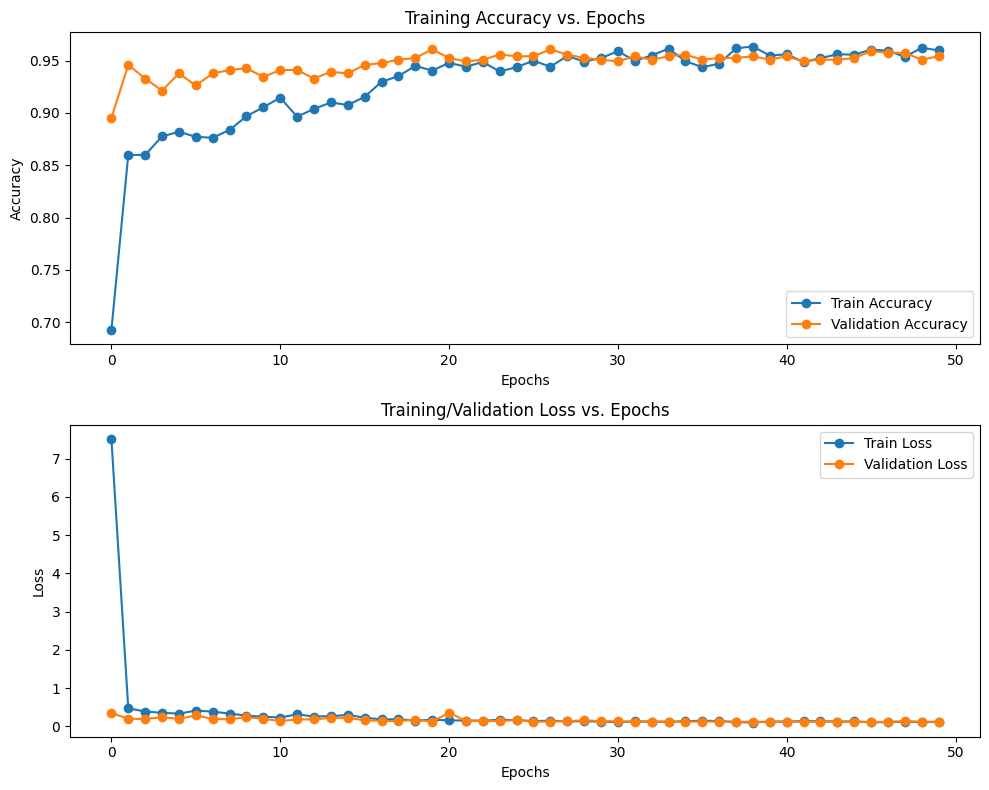

In [150]:
train_accuracy = inc_hist.history['accuracy']
val_accuracy = inc_hist.history['val_accuracy']
train_loss = inc_hist.history['loss']
val_loss = inc_hist.history['val_loss']

# If you have the learning rate in the history, pass it to the function
if 'lr' in inc_hist.history:
    learning_rate = inc_hist.history['lr']
    plot_training_history(train_accuracy, val_accuracy, train_loss, val_loss, learning_rate)
else:
    plot_training_history(train_accuracy, val_accuracy, train_loss, val_loss)

### e. Testing the Model on Test Set

In [151]:
predictions = generate_predictions_and_save(model, test_data_dir, '/kaggle/working/predictions4.csv' )

 7/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

W0000 00:00:1711178702.689927     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step
Predictions saved to: /kaggle/working/predictions4.csv


W0000 00:00:1711178709.020140     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### f. Model Prediction on the Test Dataset

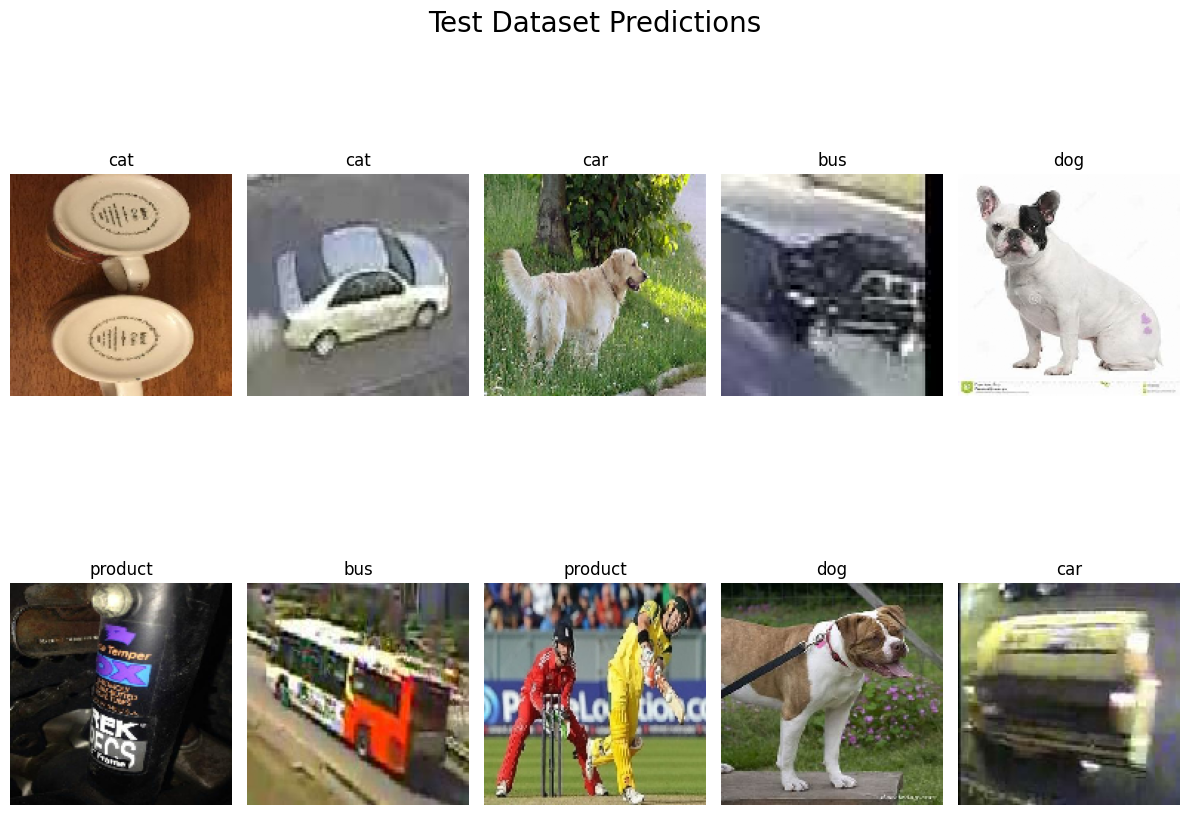

In [152]:
visualize_predictions(model, test_data_dir, predictions, num_images=10)